# RECOURSE ALGO APPLIED TO COMPAS USING LOCO SCORES 

In [1]:
import pandas as pd
import numpy as np
import cvxpy as cvx
import xgboost
from sklearn.metrics import roc_curve, auc, confusion_matrix, roc_auc_score
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
xgboost.__version__
from scipy.linalg import svd
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA, NMF
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import sklearn
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Read in data and filter out the un-needed stuff

In [2]:
file_name = './compas-scores-two-years.csv'
full_data = pd.read_csv(file_name)
full_data.race.value_counts()

print(full_data.shape)

# remove groups with few instances 
full_data = full_data.query("race != 'Asian'").query("race != 'Native American'")

# group by felony or misdemenor charge
full_data.groupby(['c_charge_degree','is_recid'])['id'].count().reset_index()

# turn charge degree to numbers 
full_data['c_charge_degree'] = pd.Categorical(full_data['c_charge_degree'])
# change numbers into dummies (1 for present 0 for absent)
dummies = pd.get_dummies(full_data['c_charge_degree'], prefix='charge')
full_data = pd.concat([full_data, dummies], axis=1)

# remove bad data
full_data = full_data.query("days_b_screening_arrest <= 30") \
        .query("days_b_screening_arrest >= -30")\
        .query("is_recid != -1")\
        .query("c_charge_degree != 'O'") \
        .query("score_text != 'N/A'" )

print(full_data.shape)

# randomize race for later use
full_data['race_random'] = np.random.permutation(full_data['race'])

# check how many random to the same thing
np.sum(full_data['race']==full_data['race_random'])

# check counts of recidivism by race
full_data.groupby(['race','is_recid'])['id'].count().reset_index()

# keep relevant columns 
columns_kept = ['sex', 'age', 'age_cat', 'race', 'juv_fel_count', 'priors_count', 'c_charge_degree', \
                'is_recid', 'decile_score', 'two_year_recid', 'c_jail_in', 'c_jail_out', 'race_random', \
                'charge_F', 'charge_M', 'score_text']
full_data = full_data.loc[:, columns_kept]

full_data.head()

(7214, 53)
(6130, 55)


,sex,age,age_cat,race,juv_fel_count,priors_count,c_charge_degree,is_recid,decile_score,two_year_recid,c_jail_in,c_jail_out,race_random,charge_F,charge_M,score_text
0,Male,69,Greater than 45,Other,0,0,F,0,1,0,2013-08-13 06:03:42,2013-08-14 05:41:20,Caucasian,1,0,Low
1,Male,34,25 - 45,African-American,0,0,F,1,3,1,2013-01-26 03:45:27,2013-02-05 05:36:53,African-American,1,0,Low
2,Male,24,Less than 25,African-American,0,4,F,1,4,1,2013-04-13 04:58:34,2013-04-14 07:02:04,Caucasian,1,0,Low
5,Male,44,25 - 45,Other,0,0,M,0,1,0,2013-11-30 04:50:18,2013-12-01 12:28:56,African-American,0,1,Low
6,Male,41,25 - 45,Caucasian,0,14,F,1,6,1,2014-02-18 05:08:24,2014-02-24 12:18:30,African-American,1,0,Medium


### turn text data into useable labels

In [3]:
learning_data = full_data.copy(deep=True)
features_to_transform = ['age_cat', 'sex', 'race', 'c_charge_degree']

for feature in features_to_transform:
    dummies = pd.get_dummies(learning_data[feature], prefix=feature)
    learning_data = pd.concat([learning_data, dummies], axis = 1)
learning_data.head()

learning_data.columns = learning_data.columns.str.replace('-', '_')

learning_data['score_factor'] = np.where(learning_data['score_text'] == 'Low', 'Low', 'MediumHigh')
dummies = pd.get_dummies(learning_data['score_factor'])
learning_data = pd.concat([learning_data, dummies] , axis = 1)
learning_data.head()

,sex,age,age_cat,race,juv_fel_count,priors_count,c_charge_degree,is_recid,decile_score,two_year_recid,...,sex_Male,race_African_American,race_Caucasian,race_Hispanic,race_Other,c_charge_degree_F,c_charge_degree_M,score_factor,Low,MediumHigh
0,Male,69,Greater than 45,Other,0,0,F,0,1,0,...,1,0,0,0,1,1,0,Low,1,0
1,Male,34,25 - 45,African-American,0,0,F,1,3,1,...,1,1,0,0,0,1,0,Low,1,0
2,Male,24,Less than 25,African-American,0,4,F,1,4,1,...,1,1,0,0,0,1,0,Low,1,0
5,Male,44,25 - 45,Other,0,0,M,0,1,0,...,1,0,0,0,1,0,1,Low,1,0
6,Male,41,25 - 45,Caucasian,0,14,F,1,6,1,...,1,0,1,0,0,1,0,MediumHigh,0,1


### Train the model

In [4]:
X_Labels = ['sex_Male', 'sex_Female', 'age', 'race_African_American', 'race_Caucasian', 'priors_count',\
            'race_Hispanic', 'race_Other', 'juv_fel_count', 'c_charge_degree_F', 'c_charge_degree_M']
Y_Labels = ['Low']


X =  learning_data.loc[:, X_Labels]
Y =  learning_data.loc[:, Y_Labels]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size =  0.2, random_state =  4)

# find and later remove linearly correlated pairs (not for xgboost but for LOCO later)
corr_thresh = .7
for column_a in X.columns:
    for column_b in X.columns:
        if column_a is not column_b:
            if X[column_a].corr(X[column_b]) > corr_thresh:
                print(column_a + " " + column_b)
    

xgb_full = xgboost.DMatrix(X, label=Y)
xgb_train =  xgboost.DMatrix(X_train, label = Y_train)
xgb_test = xgboost.DMatrix(X_test, label = Y_test)
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 4,
    "objective": 'binary:logistic',
    "eval_metric":"auc",
    "tree_method": 'gpu_hist',
    "subsample": 0.5
}
#model_train = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval=1000)
model = xgboost.train(params, xgb_train, 10000, evals = [(xgb_test, "test")], verbose_eval= 1000)
xgboost.cv(params,xgb_full, nfold = 3, metrics="auc" , num_boost_round=10)
learning_data['pred'] = model.predict(xgb_full)


[0]	test-auc:0.81849
[1000]	test-auc:0.84334
[2000]	test-auc:0.84634
[3000]	test-auc:0.84599
[4000]	test-auc:0.84558
[5000]	test-auc:0.84475
[6000]	test-auc:0.84375
[7000]	test-auc:0.84289
[8000]	test-auc:0.84229
[9000]	test-auc:0.84161
[9999]	test-auc:0.84089


In [5]:
plt.hist(learning_data['pred'], bins = 20)
plt.show()

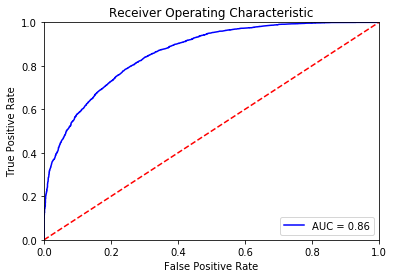

Optimal Threshold obtained using difference of TPR and FPR 0.5727081


In [6]:
%matplotlib inline
fpr, tpr , thresholds = roc_curve(learning_data['Low'], learning_data['pred'])
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

optimal_threshold = thresholds[np.argmax(tpr - fpr)]
print("Optimal Threshold obtained using difference of TPR and FPR " + str(optimal_threshold))
learning_data['y_pred'] = np.where(learning_data['pred'] > optimal_threshold, 1, 0)

### find LOCO scores

progress: 0.0(sex_Male)
progress: 0.09090909090909091(sex_Female)
progress: 0.18181818181818182(age)
progress: 0.2727272727272727(race_African_American)
progress: 0.36363636363636365(race_Caucasian)
progress: 0.45454545454545453(priors_count)
progress: 0.5454545454545454(race_Hispanic)
progress: 0.6363636363636364(race_Other)
progress: 0.7272727272727273(juv_fel_count)
progress: 0.8181818181818182(c_charge_degree_F)
progress: 0.9090909090909091(c_charge_degree_M)

average loco score

age_loco                      0.043225
race_Other_loco               0.041399
race_African_American_loco    0.021791
race_Hispanic_loco            0.018291
c_charge_degree_F_loco        0.010740
race_Caucasian_loco           0.004399
c_charge_degree_M_loco        0.000883
sex_Female_loco              -0.002043
sex_Male_loco                -0.011915
juv_fel_count_loco           -0.056811
priors_count_loco            -0.142059
dtype: float32

average loco score only when ranked MediumHigh risk

age_loco     

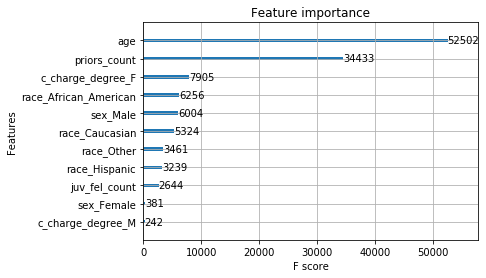

,sex_Male_loco,sex_Female_loco,age_loco,race_African_American_loco,race_Caucasian_loco,priors_count_loco,race_Hispanic_loco,race_Other_loco,juv_fel_count_loco,c_charge_degree_F_loco,c_charge_degree_M_loco,race
0,0.000562,0.000293,-0.091844,-0.001052,-0.002503,-0.014639,0.001024,-0.004647,-0.001818,0.003161,0.000107,Other
1,0.037075,0.007424,0.118507,0.111012,-0.011112,-0.420599,0.043641,0.131935,-0.116323,0.063294,0.005679,African-American
2,-0.030697,-0.005557,0.225824,0.014665,0.005957,-0.011885,-0.006283,0.012167,-0.057672,-0.027650,-0.002864,African-American
5,0.000948,0.000292,-0.050390,-0.005150,-0.000332,-0.039928,0.001118,-0.016330,-0.003174,-0.002699,0.000005,Other
6,-0.044711,-0.008441,-0.055817,-0.065242,-0.038924,0.521604,0.013695,0.054296,-0.000391,0.018636,0.000868,Caucasian


In [7]:
loco_data = pd.DataFrame()

for index, feature_to_null in enumerate(X_Labels):
    print("progress: " + str(index/len(X_Labels)) + "(" + feature_to_null + ")")
    
    loco_frame = learning_data.copy(deep=True)
    loco_frame[feature_to_null] = np.nan
    
    loco_X =  loco_frame.loc[:, X_Labels]
    loco_Y =  loco_frame.loc[:, Y_Labels]
    
    xgb_loco = xgboost.DMatrix(loco_X, label=loco_Y)
    
    loco_pred = model.predict(xgb_loco) - learning_data['pred']
    
    loco_data[feature_to_null+"_loco"] = loco_pred

loco_data["Low"] = learning_data["Low"]
    
loco_means = loco_data.drop("Low", axis=1).mean(axis=0).sort_values(ascending=False)
loco_op_means = loco_data.query("Low != 1").drop("Low", axis=1).mean(axis=0).sort_values(ascending=False)
loco_abs_means = loco_data.abs().drop("Low", axis=1).mean(axis=0).sort_values(ascending=False)
loco_median = loco_data.drop("Low", axis=1).median(axis=0).sort_values(ascending=False)
loco_data = pd.concat([loco_data, learning_data['race']], axis=1)

print()
print("average loco score")
print()
print(loco_means)
print()
print("average loco score only when ranked MediumHigh risk")
print()
print(loco_op_means)
print()
print("average of abs of loco score")
print()
print(loco_abs_means)
print()
print("median loco score")
print()
print(loco_median)

# compare them to the xgboost feature importance
from xgboost import plot_importance
ax = plot_importance(model)
plt.show()

loco_data = loco_data.drop("Low", axis=1)

loco_data.head()


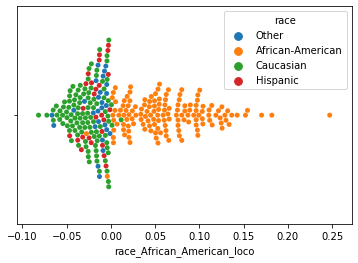

In [8]:
%matplotlib inline
loco_data.reindex(np.random.permutation(loco_data.index))
num_plot_points = 300

sns.swarmplot(x="race_African_American_loco", 
              hue="race", data=loco_data[:num_plot_points], 
              y=[""]*num_plot_points)


### Start recourse using derived predictor method from equalized odd paper

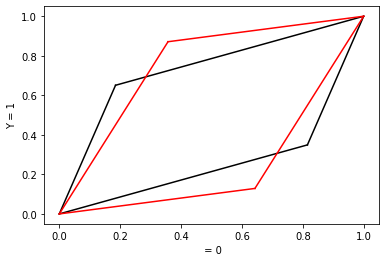

In [9]:
%matplotlib inline
def find_rate_class(prediction: str, pred_high, label: str, label_val, class_name: str, class_val, data):
    filtered_data = data.query(class_name + " == " + str(class_val)).query(label + " == " + str(label_val))
    total_data = filtered_data.shape[0]
    total_ones = filtered_data.query(prediction + " == " + str(pred_high)).shape[0]
    return total_ones/total_data

aa_tpr = find_rate_class("y_pred", 1, "Low", 1, "race_African_American", 1, learning_data)
aa_fpr = find_rate_class("y_pred", 1, "Low", 0, "race_African_American", 1, learning_data)
# race_Caucasian
o_tpr = find_rate_class("y_pred", 1, "Low", 1, "race_African_American", 0, learning_data)
o_fpr = find_rate_class("y_pred", 1, "Low", 0, "race_African_American", 0, learning_data)

# plot convex hull (fpr = x axis tpr = y axis)
gamma_aa_1 = (find_rate_class("y_pred", 1, "Low", 0, "race_African_American", 1, learning_data), 
              find_rate_class("y_pred", 1, "Low", 1, "race_African_American", 1, learning_data))
gamma_aa_0 = (find_rate_class("y_pred", 0, "Low", 0, "race_African_American", 1, learning_data), 
              find_rate_class("y_pred", 0, "Low", 1, "race_African_American", 1, learning_data))

gamma_o_1 = (find_rate_class("y_pred", 1, "Low", 0, "race_African_American", 0, learning_data), 
             find_rate_class("y_pred", 1, "Low", 1, "race_African_American", 0, learning_data))
gamma_o_0 = (find_rate_class("y_pred", 0, "Low", 0, "race_African_American", 0, learning_data), 
             find_rate_class("y_pred", 0, "Low", 1, "race_African_American", 0, learning_data))


points = np.array([(0,0), gamma_aa_0, gamma_aa_1, (1,1)])
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex,0], points[simplex,1], 'k-')

points = np.array([(0,0), gamma_o_0, gamma_o_1, (1,1)])
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex,0], points[simplex,1], 'r-')
plt.ylabel('Y = 1(TPR)')
plt.xlabel('Y = 0(FPR)')

plt.show();

### Equalized Odds

In [10]:
from collections import namedtuple

class Model(namedtuple('Model', 'pred label')):
    def logits(self):
        raw_logits = np.clip(np.log(self.pred / (1 - self.pred)), -100, 100)
        return raw_logits

    def num_samples(self):
        return len(self.pred)

    def base_rate(self):
        """
        Percentage of samples belonging to the positive class
        """
        return np.mean(self.label)

    def accuracy(self):
        return self.accuracies().mean()

    def precision(self):
        return (self.label[self.pred.round() == 1]).mean()

    def recall(self):
        return (self.label[self.label == 1].round()).mean()

    def tpr(self):
        """
        True positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 1))

    def fpr(self):
        """
        False positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 0))

    def tnr(self):
        """
        True negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 0))

    def fnr(self):
        """
        False negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 1))

    def fn_cost(self):
        """
        Generalized false negative cost
        """
        return 1 - self.pred[self.label == 1].mean()

    def fp_cost(self):
        """
        Generalized false positive cost
        """
        return self.pred[self.label == 0].mean()

    def accuracies(self):
        return self.pred.round() == self.label

    def eq_odds(self, othr, mix_rates=None):
        has_mix_rates = not (mix_rates is None)
        if not has_mix_rates:
            mix_rates = self.eq_odds_optimal_mix_rates(othr)
        sp2p, sn2p, op2p, on2p = tuple(mix_rates)

        self_fair_pred = self.pred.copy()
        self_pp_indices, = np.nonzero(self.pred.round())
        self_pn_indices, = np.nonzero(1 - self.pred.round())
        np.random.shuffle(self_pp_indices)
        np.random.shuffle(self_pn_indices)

        n2p_indices = self_pn_indices[:int(len(self_pn_indices) * sn2p)]
        self_fair_pred[n2p_indices] = 1 - self_fair_pred[n2p_indices]
        p2n_indices = self_pp_indices[:int(len(self_pp_indices) * (1 - sp2p))]
        self_fair_pred[p2n_indices] = 1 - self_fair_pred[p2n_indices]

        othr_fair_pred = othr.pred.copy()
        othr_pp_indices, = np.nonzero(othr.pred.round())
        othr_pn_indices, = np.nonzero(1 - othr.pred.round())
        np.random.shuffle(othr_pp_indices)
        np.random.shuffle(othr_pn_indices)

        n2p_indices = othr_pn_indices[:int(len(othr_pn_indices) * on2p)]
        othr_fair_pred[n2p_indices] = 1 - othr_fair_pred[n2p_indices]
        p2n_indices = othr_pp_indices[:int(len(othr_pp_indices) * (1 - op2p))]
        othr_fair_pred[p2n_indices] = 1 - othr_fair_pred[p2n_indices]

        fair_self = Model(self_fair_pred, self.label)
        fair_othr = Model(othr_fair_pred, othr.label)

        if not has_mix_rates:
            return fair_self, fair_othr, mix_rates
        else:
            return fair_self, fair_othr

    def eq_odds_optimal_mix_rates(self, othr):
        sbr = float(self.base_rate())
        obr = float(othr.base_rate())

        sp2p = cvx.Variable(1)
        sp2n = cvx.Variable(1)
        sn2p = cvx.Variable(1)
        sn2n = cvx.Variable(1)

        op2p = cvx.Variable(1)
        op2n = cvx.Variable(1)
        on2p = cvx.Variable(1)
        on2n = cvx.Variable(1)

        sfpr = self.fpr() * sp2p + self.tnr() * sn2p
        sfnr = self.fnr() * sn2n + self.tpr() * sp2n
        ofpr = othr.fpr() * op2p + othr.tnr() * on2p
        ofnr = othr.fnr() * on2n + othr.tpr() * op2n
        error = sfpr + sfnr + ofpr + ofnr

        sflip = 1 - self.pred
        sconst = self.pred
        oflip = 1 - othr.pred
        oconst = othr.pred

        sm_tn = np.logical_and(self.pred.round() == 0, self.label == 0)
        sm_fn = np.logical_and(self.pred.round() == 0, self.label == 1)
        sm_tp = np.logical_and(self.pred.round() == 1, self.label == 1)
        sm_fp = np.logical_and(self.pred.round() == 1, self.label == 0)

        om_tn = np.logical_and(othr.pred.round() == 0, othr.label == 0)
        om_fn = np.logical_and(othr.pred.round() == 0, othr.label == 1)
        om_tp = np.logical_and(othr.pred.round() == 1, othr.label == 1)
        om_fp = np.logical_and(othr.pred.round() == 1, othr.label == 0)

        spn_given_p = (sn2p * (sflip * sm_fn).mean() + sn2n * (sconst * sm_fn).mean()) / sbr + \
                      (sp2p * (sconst * sm_tp).mean() + sp2n * (sflip * sm_tp).mean()) / sbr

        spp_given_n = (sp2n * (sflip * sm_fp).mean() + sp2p * (sconst * sm_fp).mean()) / (1 - sbr) + \
                      (sn2p * (sflip * sm_tn).mean() + sn2n * (sconst * sm_tn).mean()) / (1 - sbr)

        opn_given_p = (on2p * (oflip * om_fn).mean() + on2n * (oconst * om_fn).mean()) / obr + \
                      (op2p * (oconst * om_tp).mean() + op2n * (oflip * om_tp).mean()) / obr

        opp_given_n = (op2n * (oflip * om_fp).mean() + op2p * (oconst * om_fp).mean()) / (1 - obr) + \
                      (on2p * (oflip * om_tn).mean() + on2n * (oconst * om_tn).mean()) / (1 - obr)

        constraints = [
            sp2p == 1 - sp2n,
            sn2p == 1 - sn2n,
            op2p == 1 - op2n,
            on2p == 1 - on2n,
            sp2p <= 1,
            sp2p >= 0,
            sn2p <= 1,
            sn2p >= 0,
            op2p <= 1,
            op2p >= 0,
            on2p <= 1,
            on2p >= 0,
            spp_given_n == opp_given_n,
            spn_given_p == opn_given_p,
        ]

        prob = cvx.Problem(cvx.Minimize(error), constraints)
        prob.solve()

        res = np.array([sp2p.value, sn2p.value, op2p.value, on2p.value])
        return res

    def __repr__(self):
        return '\n'.join([
            'Accuracy:\t%.3f' % self.accuracy(),
            'F.P. cost:\t%.3f' % self.fp_cost(),
            'F.N. cost:\t%.3f' % self.fn_cost(),
            'Base rate:\t%.3f' % self.base_rate(),
            'Avg. score:\t%.3f' % self.pred.mean(),
        ])

In [11]:
test_and_val_data = learning_data[['pred', 'Low', 'race_African_American', 'race_Caucasian']]
    
order = np.random.permutation(len(test_and_val_data))
val_indices = order[0::2]
test_indices = order[1::2]
val_data = test_and_val_data.iloc[val_indices]
test_data = test_and_val_data.iloc[test_indices]

group_0_val_data = val_data[val_data['race_African_American'] == 1]
group_1_val_data = val_data[val_data['race_African_American'] == 0]
group_0_test_data = test_data[test_data['race_African_American'] == 1]
group_1_test_data = test_data[test_data['race_African_American'] == 0]


In [12]:
group_0_val_model  = Model(group_0_val_data['pred'].as_matrix(), group_0_val_data['Low'].as_matrix())
group_1_val_model  = Model(group_1_val_data['pred'].as_matrix(), group_1_val_data['Low'].as_matrix())
group_0_test_model = Model(group_0_test_data['pred'].as_matrix(), group_0_test_data['Low'].as_matrix())
group_1_test_model = Model(group_1_test_data['pred'].as_matrix(), group_1_test_data['Low'].as_matrix())

# Find mixing rates for equalized odds models
_, _, mix_rates = Model.eq_odds(group_0_val_model, group_1_val_model)

# Apply the mixing rates to the test models
eq_odds_group_0_test_model, eq_odds_group_1_test_model = Model.eq_odds(group_0_test_model,
                                                                       group_1_test_model,
                                                                       mix_rates)

# Print results on test model
print('Original group African American model:\n%s\n' % repr(group_0_test_model))
print('Original group Caucasian model:\n%s\n' % repr(group_1_test_model))
print('Equalized odds group African American model:\n%s\n' % repr(eq_odds_group_0_test_model))
print('Equalized odds group Caucasian model:\n%s\n' % repr(eq_odds_group_1_test_model))

Original group African American model:
Accuracy:	0.740
F.P. cost:	0.289
F.N. cost:	0.394
Base rate:	0.414
Avg. score:	0.420

Original group Caucasian model:
Accuracy:	0.803
F.P. cost:	0.444
F.N. cost:	0.201
Base rate:	0.680
Avg. score:	0.685

Equalized odds group African American model:
Accuracy:	0.655
F.P. cost:	0.418
F.N. cost:	0.370
Base rate:	0.414
Avg. score:	0.506

Equalized odds group Caucasian model:
Accuracy:	0.682
F.P. cost:	0.398
F.N. cost:	0.357
Base rate:	0.680
Avg. score:	0.564



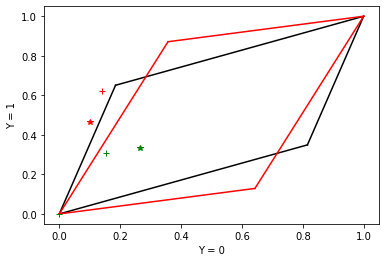

In [13]:
points = np.array([(0,0), gamma_aa_0, gamma_aa_1, (1,1)])
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex,0], points[simplex,1], 'k-')

points = np.array([(0,0), gamma_o_0, gamma_o_1, (1,1)])
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex,0], points[simplex,1], 'r-')
    
plt.plot(group_0_test_model.fpr(), group_0_test_model.tpr(), 'k+')
plt.plot(group_1_test_model.fpr(), group_1_test_model.tpr(), 'r+')
plt.plot(eq_odds_group_0_test_model.fpr(), eq_odds_group_0_test_model.tpr(), 'k*')
plt.plot(eq_odds_group_1_test_model.fpr(), eq_odds_group_1_test_model.tpr(), 'r*')

plt.plot(0, 0, 'g+')

plt.ylabel('Y = 1')
plt.xlabel('Y = 0')

plt.show();

### Calibrated Equalized Odds 
note: xgboost does not return calibrated results so this is mostly just to familiarize with the process

In [14]:
class Calib_Model(namedtuple('Calib_Model', 'pred label')):
    def logits(self):
        raw_logits = np.clip(np.log(self.pred / (1 - self.pred)), -100, 100)
        return raw_logits

    def num_samples(self):
        return len(self.pred)

    def base_rate(self):
        """
        Percentage of samples belonging to the positive class
        """
        return np.mean(self.label)

    def accuracy(self):
        return self.accuracies().mean()

    def precision(self):
        return (self.label[self.pred.round() == 1]).mean()

    def recall(self):
        return (self.label[self.label == 1].round()).mean()

    def tpr(self):
        """
        True positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 1))

    def fpr(self):
        """
        False positive rate
        """
        return np.mean(np.logical_and(self.pred.round() == 1, self.label == 0))

    def tnr(self):
        """
        True negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 0))

    def fnr(self):
        """
        False negative rate
        """
        return np.mean(np.logical_and(self.pred.round() == 0, self.label == 1))

    def fn_cost(self):
        """
        Generalized false negative cost
        """
        return 1 - self.pred[self.label == 1].mean()

    def fp_cost(self):
        """
        Generalized false positive cost
        """
        return self.pred[self.label == 0].mean()

    def accuracies(self):
        return self.pred.round() == self.label

    def calib_eq_odds(self, other, fp_rate, fn_rate, mix_rates=None):
        if fn_rate == 0:
            self_cost = self.fp_cost()
            other_cost = other.fp_cost()
            print(self_cost, other_cost)
            self_trivial_cost = self.trivial().fp_cost()
            other_trivial_cost = other.trivial().fp_cost()
        elif fp_rate == 0:
            self_cost = self.fn_cost()
            other_cost = other.fn_cost()
            self_trivial_cost = self.trivial().fn_cost()
            other_trivial_cost = other.trivial().fn_cost()
        else:
            self_cost = self.weighted_cost(fp_rate, fn_rate)
            other_cost = other.weighted_cost(fp_rate, fn_rate)
            self_trivial_cost = self.trivial().weighted_cost(fp_rate, fn_rate)
            other_trivial_cost = other.trivial().weighted_cost(fp_rate, fn_rate)

        other_costs_more = other_cost > self_cost
        self_mix_rate = (other_cost - self_cost) / (self_trivial_cost - self_cost) if other_costs_more else 0
        other_mix_rate = 0 if other_costs_more else (self_cost - other_cost) / (other_trivial_cost - other_cost)

        # New classifiers
        self_indices = np.random.permutation(len(self.pred))[:int(self_mix_rate * len(self.pred))]
        self_new_pred = self.pred.copy()
        self_new_pred[self_indices] = self.base_rate()
        calib_eq_odds_self = Calib_Model(self_new_pred, self.label)

        other_indices = np.random.permutation(len(other.pred))[:int(other_mix_rate * len(other.pred))]
        other_new_pred = other.pred.copy()
        other_new_pred[other_indices] = other.base_rate()
        calib_eq_odds_other = Calib_Model(other_new_pred, other.label)

        if mix_rates is None:
            return calib_eq_odds_self, calib_eq_odds_other, (self_mix_rate, other_mix_rate)
        else:
            return calib_eq_odds_self, calib_eq_odds_other

    def trivial(self):
        """
        Given a classifier, produces the trivial classifier
        (i.e. a model that just returns the base rate for every prediction)
        """
        base_rate = self.base_rate()
        pred = np.ones(len(self.pred)) * base_rate
        return Calib_Model(pred, self.label)

    def weighted_cost(self, fp_rate, fn_rate):
        """
        Returns the weighted cost
        If fp_rate = 1 and fn_rate = 0, returns self.fp_cost
        If fp_rate = 0 and fn_rate = 1, returns self.fn_cost
        If fp_rate and fn_rate are nonzero, returns fp_rate * self.fp_cost * (1 - self.base_rate) +
            fn_rate * self.fn_cost * self.base_rate
        """
        norm_const = float(fp_rate + fn_rate) if (fp_rate != 0 and fn_rate != 0) else 1
        res = fp_rate / norm_const * self.fp_cost() * (1 - self.base_rate()) + \
            fn_rate / norm_const * self.fn_cost() * self.base_rate()
        return res

    def __repr__(self):
        return '\n'.join([
            'Accuracy:\t%.3f' % self.accuracy(),
            'F.P. cost:\t%.3f' % self.fp_cost(),
            'F.N. cost:\t%.3f' % self.fn_cost(),
            'Base rate:\t%.3f' % self.base_rate(),
            'Avg. score:\t%.3f' % self.pred.mean(),
        ])

In [15]:
test_and_val_data = learning_data[['pred', 'Low', 'race_African_American', 'race_Caucasian']]
    
order = np.random.permutation(len(test_and_val_data))
val_indices = order[0::2]
test_indices = order[1::2]
val_data = test_and_val_data.iloc[val_indices]
test_data = test_and_val_data.iloc[test_indices]

cali_group_0_val_data = val_data[val_data['race_African_American'] == 1]
cali_group_1_val_data = val_data[val_data['race_African_American'] == 0]
cali_group_0_test_data = test_data[test_data['race_African_American'] == 1]
cali_group_1_test_data = test_data[test_data['race_African_American'] == 0]


In [18]:
cost_constraint = 'weighted'
if cost_constraint == 'fnr':
    fn_rate = 1
    fp_rate = 0
elif cost_constraint == 'fpr':
    fn_rate = 0
    fp_rate = 1
elif cost_constraint == 'weighted':
    fn_rate = 1
    fp_rate = 1

group_0_val_cali_model  = Calib_Model(cali_group_0_val_data['pred'].as_matrix(), cali_group_0_val_data['Low'].as_matrix())
group_1_val_cali_model  = Calib_Model(cali_group_1_val_data['pred'].as_matrix(), cali_group_1_val_data['Low'].as_matrix())
group_0_test_cali_model = Calib_Model(cali_group_0_test_data['pred'].as_matrix(), cali_group_0_test_data['Low'].as_matrix())
group_1_test_cali_model = Calib_Model(cali_group_1_test_data['pred'].as_matrix(), cali_group_1_test_data['Low'].as_matrix())

# Find mixing rates for equalized odds models
_, _, cali_mix_rates = Calib_Model.calib_eq_odds(group_0_val_cali_model, group_1_val_cali_model, fp_rate, fn_rate)

# Apply the mixing rates to the test models
calib_eq_odds_group_0_test_model, calib_eq_odds_group_1_test_model = Calib_Model.calib_eq_odds(group_0_test_cali_model,
                                                                                             group_1_test_cali_model,
                                                                                             fp_rate, fn_rate,
                                                                                             cali_mix_rates)

# Print results on test model
print('Original group African American model:\n%s\n' % repr(group_0_test_model))
print('Original group Caucasian model:\n%s\n' % repr(group_1_test_model))
print('Equalized odds group African American model:\n%s\n' % repr(calib_eq_odds_group_0_test_model))
print('Equalized odds group Caucasian model:\n%s\n' % repr(calib_eq_odds_group_1_test_model))

Original group African American model:
Accuracy:	0.740
F.P. cost:	0.289
F.N. cost:	0.394
Base rate:	0.414
Avg. score:	0.420

Original group Caucasian model:
Accuracy:	0.803
F.P. cost:	0.444
F.N. cost:	0.201
Base rate:	0.680
Avg. score:	0.685

Equalized odds group African American model:
Accuracy:	0.748
F.P. cost:	0.288
F.N. cost:	0.382
Base rate:	0.414
Avg. score:	0.424

Equalized odds group Caucasian model:
Accuracy:	0.763
F.P. cost:	0.555
F.N. cost:	0.232
Base rate:	0.696
Avg. score:	0.703



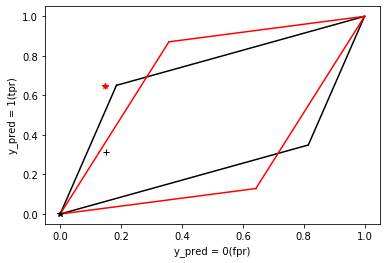

In [17]:
points = np.array([(0,0), gamma_aa_0, gamma_aa_1, (1,1)])
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex,0], points[simplex,1], 'k-')

points = np.array([(0,0), gamma_o_0, gamma_o_1, (1,1)])
hull = ConvexHull(points)
for simplex in hull.simplices:
    plt.plot(points[simplex,0], points[simplex,1], 'r-')
    
plt.plot(group_0_test_cali_model.fpr(), group_0_test_cali_model.tpr(), 'k+')
plt.plot(group_1_test_cali_model.fpr(), group_1_test_cali_model.tpr(), 'r+')
plt.plot(calib_eq_odds_group_0_test_model.fpr(), calib_eq_odds_group_0_test_model.tpr(), 'k*')
plt.plot(calib_eq_odds_group_1_test_model.fpr(), calib_eq_odds_group_1_test_model.tpr(), 'r*')

plt.ylabel('y_pred = 1(tpr)')
plt.xlabel('y_pred = 0(fpr)')

plt.show();